## Variational autoencoder for MNIST

Inspired by https://github.com/lyeoni/pytorch-mnist-VAE/

In [17]:
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm.auto import trange, tqdm


# Use GPU if possible
if torch.cuda.is_available():
    DEVICE = "cuda:0"
else:
    DEVICE = "cpu"

In [42]:
# Get MNIST dataset
train_dataset = datasets.MNIST(
    root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True
)
val_dataset = datasets.MNIST(
    root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False
)
# Image dimension
n_pix = train_dataset[0][0].shape[-1]

In [45]:
# Set up dataloaders
batch_size = 128
num_workers = 2
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
)

In [32]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # Shared layers
        self.shared_net = nn.Sequential(
            nn.Linear(n_pix**2, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True)
        )
        # Final linear layers for computing mean and log std
        self.mu_net = nn.Linear(hidden_dim, z_dim)
        self.log_var_net = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        z = x.view(-1, n_pix**2)  # flatten
        z = self.shared_net(z)
        mu = self.mu_net(z)
        log_var = self.log_var_net(z)
        return mu, log_var


class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, n_pix**2),
            nn.Sigmoid()  # ensures output is in [0, 1]
        )
    
    def forward(self, z):
        # Mean of decoded distribution
        return self.net(z).view(-1, 1, n_pix, n_pix)


class VAE(nn.Module):
    def __init__(self, z_dim, hidden_dim_enc, hidden_dim_dec):
        super().__init__()
        self.z_dim = z_dim
        self.encoder = Encoder(z_dim, hidden_dim_enc)
        self.decoder = Decoder(z_dim, hidden_dim_dec)
        self.register_buffer("prior_mu", torch.zeros(z_dim))
        self.register_buffer("prior_std", torch.ones(z_dim))
    
    def sample_z(self, mu, log_var):
        # Apply reparametrization trick
        sigma = (0.5 * log_var).exp()
        eps = torch.randn(self.z_dim, device=mu.device)
        return mu + eps * sigma
    
    def forward(self, x):
        # Encode x, sample z and decode
        mu, log_var = self.encoder(x)
        z = self.sample_z(mu, log_var)
        x_recon = self.decoder(z)
        return x_recon, mu, log_var
    
    def generate(self, n=1):
        z = dist.Normal(self.prior_mu, self.prior_std).sample((n,))
        return self.decoder(z)


def get_loss(x, x_recon, mu, log_var):
    bce = F.binary_cross_entropy(x_recon, x, reduction="sum")
    kl = -0.5 * (1 + log_var - mu**2 - log_var.exp()).sum()
    return bce + kl

In [63]:
# Initialize networks
vae = VAE(z_dim=4, hidden_dim_enc=512, hidden_dim_dec=512)
vae.to(DEVICE)

# Train
vae.train()
optimizer = optim.Adam(vae.parameters(), lr=4e-4)
n_epochs = 10
logging_frequency = 1
tr_losses = []
val_losses = []
with trange(n_epochs) as pbar:
    for epoch in pbar:
        # Training loop
        for batch_idx, (x, _) in enumerate(train_loader):
            # Put data on GPU if necessary
            x = x.to(DEVICE)
            # Clear gradients
            optimizer.zero_grad()
            # Get encoded distribution's parameters and the reconstruction
            x_recon, mu, log_var = vae(x)
            # Compute loss
            loss = get_loss(x, x_recon, mu, log_var)
            # Backpropagate
            loss.backward()
            # Take optimization step
            optimizer.step()

            # Logging
            tr_losses.append(loss.item())
            if epoch % logging_frequency == 0:
                if len(val_losses) == 0:
                    pbar.set_description(f"train loss: {tr_losses[-1]:.5g}")
                else:
                    pbar.set_description(
                        f"train loss: {tr_losses[-1]:.5g}, val loss: {val_losses[-1]:.5g}"
                    )

        # Validation loop
        vae.eval()
        # Accelerates calculations by not saving the computational graph
        with torch.no_grad():
            for batch_idx, (x, _) in enumerate(val_loader):
                # Compute loss
                x = x.to(DEVICE)
                x_recon, mu, log_var = vae(x)
                loss = get_loss(x, x_recon, mu, log_var)
                val_losses.append(loss.item())

                # Logging
                if epoch % logging_frequency == 0:
                    pbar.set_description(
                        f"train loss: {tr_losses[-1]:.5g}, val loss: {val_losses[-1]:.5g}"
                    )

vae.eval();  # semicolon hides output

  0%|          | 0/10 [00:00<?, ?it/s]

VAE(
  (encoder): Encoder(
    (shared_net): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ReLU(inplace=True)
    )
    (mu_net): Linear(in_features=512, out_features=4, bias=True)
    (log_var_net): Linear(in_features=512, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (net): Sequential(
      (0): Linear(in_features=4, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=512, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
)

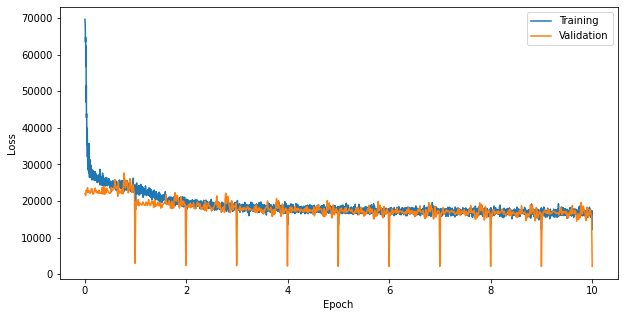

In [68]:
# Plot training and validation loss to check for overfitting
plt.figure(figsize=(10, 5))
plt.plot(torch.linspace(0, n_epochs, len(tr_losses)), tr_losses, label="Training")
plt.plot(torch.linspace(0, n_epochs, len(val_losses)), val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

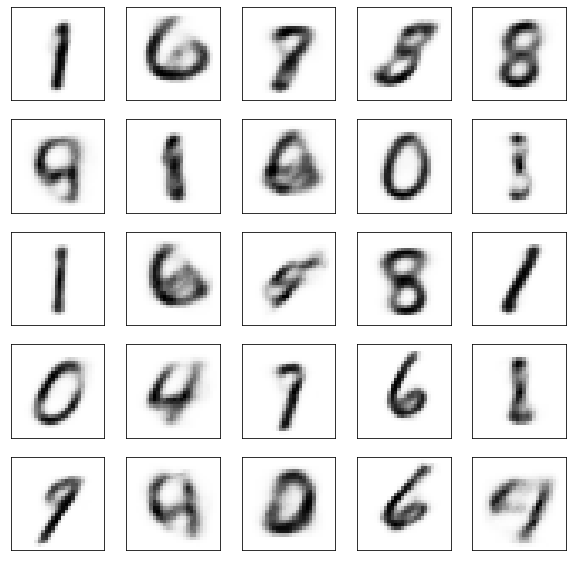

In [69]:
# Plot generated digits!
sqrt_n_samples = 5
with torch.no_grad():
    x_samples = vae.generate(sqrt_n_samples**2).detach().cpu()[:, 0, :, :]

fig, axes = plt.subplots(
    sqrt_n_samples, sqrt_n_samples, figsize=(2 * sqrt_n_samples, 2 * sqrt_n_samples)
)
for x, ax in zip(x_samples, axes.flatten()):
    ax.imshow(x, cmap="Greys")
    ax.set_xticks([])
    ax.set_yticks([])